In [1]:
import pymatgen as pmg
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.core.periodic_table import Element
from pymatgen.electronic_structure.core import Spin, Orbital
from pymatgen.electronic_structure.dos import Dos, DOS
import functools
import numpy as np

from os.path import expanduser
home = expanduser('~')

from matplotlib.pyplot import figure

import matplotlib.pyplot as pyplot
from scipy.integrate import trapz, simps, cumtrapz

import warnings
warnings.filterwarnings("ignore")


def integrate(axis, line_idx, start, end, label=None, down=False, color=None):
    """Integrates the given DoS data"""
    line = axis.get_lines()[line_idx]
    
    x = line.get_xdata()[:3001]
    y = line.get_ydata()[:3001]
    
    if down:
        x = np.flip(x)
        y = np.flip(y)
    
    integral = cumtrapz(y, x=x, initial=0)
    
    pyplot.plot(x,y, label=label, color=color)
    pyplot.plot(x, integral, color=color, linestyle='--', label=label+' int')
    pyplot.axvline(x=x[0], linestyle='--', color='grey')
    pyplot.axvline(x=x[-1], linestyle='--', color='grey')
    pyplot.axhline(y=0, color='k')
    pyplot.grid(1)
    pyplot.legend()


def norm_dos(dos, factor):
    dos_dict = dos.as_dict()
    for key in dos_dict['densities'].keys():
        dos_dict['densities'][key] = np.array(dos_dict['densities'][key])/factor
    return Dos.from_dict(dos_dict)

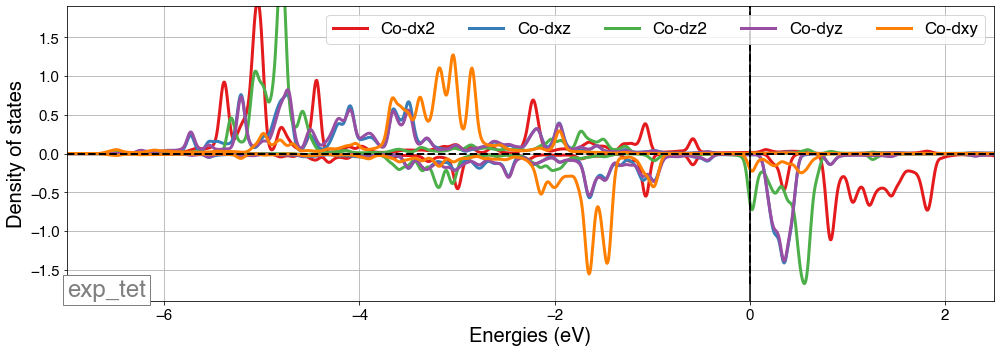

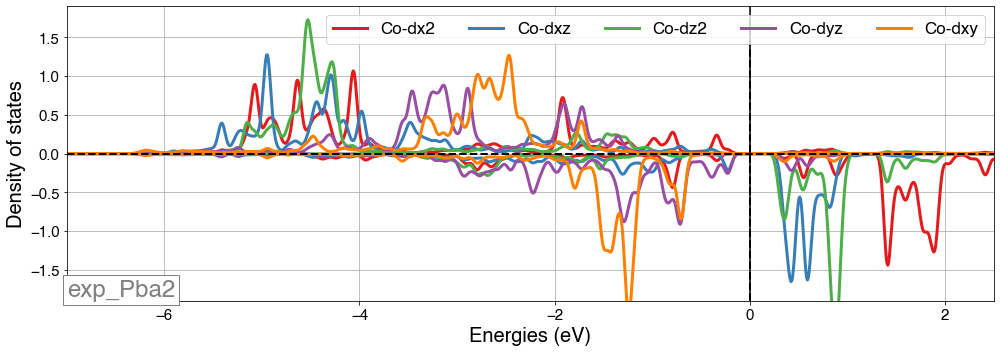

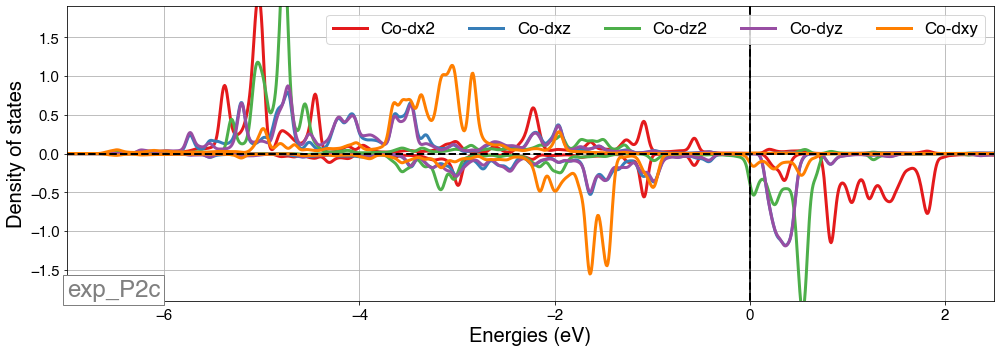

In [4]:
WIDTH = 14
HEIGHT = 5

DOS_TYPE = 'site-spin' #'element'
BY_ELEMENT = ["S"]
# PROJECTION_SITES = [[9], [9], [12]]
PROJECTION_SITES = [[11], [11], [12]]

ORBITALS_LS = [4, 5, 6, 7, 8]
ORBITAL_NAMES = ['dxy', 'dyz', 'dz2', 'dxz', 'dx2']
# ORBITALS_LS = [5, 7]
# ORBITAL_NAMES = ['dyz','dxz']
NORM_FACTOR=4

PREFIX = home + '/Projects/BaCoS2/correct_mag/PBE-struc-compare-estruc/vasprun-bands'
SUFFIX = ".xml"
ITERS_1 = ['tet', 'Pba2', 'P2c']

# LABELS_1 = [f'$M_4$ Displacement]
# LABELS_2 = ITERS_2
LABEL_PREFIX = ""
XLIMS = [[-7,2.5]]*12
# XLIMS = [[-2,1]]*12
YLIMS = [[-1.9,1.9]]*12
LABEL_FONT = 20
            
axes = []

for i, iter_1 in enumerate(ITERS_1):
#     for j, iter_2 in enumerate(ITERS_2):
        
        label = f'exp_{iter_1}'
        
            # Extract dos from vasprun
        vr = Vasprun(f'{PREFIX}-{label}{SUFFIX}')
        cdos = vr.complete_dos
        tdos = norm_dos(vr.tdos, 4)
        
        dplt = DosPlotter()

            # Add total dos
#         dplt.add_dos("Total", tdos)
        
            # Add orbital-projected DOS
        pdoss = cdos.pdos
        for site_idx in PROJECTION_SITES[i]:
            for orbital, name in zip(ORBITALS_LS, ORBITAL_NAMES):
                site = cdos.structure[site_idx]
                elem = site.species.elements[0]
                efermi = cdos.efermi
                energies = cdos.energies
                orb_dos = pdoss[site][Orbital(orbital)]
                dplt.add_dos(f'{elem}-{name}',
                             Dos(efermi, energies, orb_dos))
                
#                 for spin, spin_label in [(Spin.up, 'up'), (Spin.down, 'down')]:
#                     spin_doss = (pdoss[site][Orbital(orb_num)][spin] for orb_num in orbitals)

#                     dplt.add_dos(f'{elem}-{spin_label}', 
#                                  Dos(efermi, energies, )
                                
            # Add site doss
#         pdoss = cdos.pdos
#         for site_idx, orbitals in zip(BY_SITE, ORBITALS_LS):
#             site = cdos.structure[site_idx]
#             elem = site.species.elements[0]
#             efermi = cdos.efermi
#             energies = cdos.energies
#             for spin, spin_label in [(Spin.up, 'up'), (Spin.down, 'down')]:
#                 spin_doss = (pdoss[site][Orbital(orb_num)][spin] for orb_num in orbitals)
                
#                 dplt.add_dos(f'{elem}-{spin_label}', 
#                              Dos(efermi, energies, {spin: sum(spin_doss)}))
                
        #         if DOS_TYPE == 'site':
        #             for site_idx in SITES:
        #                 site = cdos.structure[site_idx]
        #                 elem = cdos.structure[2].species.elements[0]
        #                 dos = cdos.get_site_dos()
        #                 dplt.add_dos(elem, dos)

#             # Add element dos
#         elem_doss = cdos.get_element_dos()
#         for element in BY_ELEMENT:
#             dplt.add_dos(element, norm_dos(elem_doss[Element(element)], 4))

            # Customize plot
        dos_plot = dplt.get_plot()
        dos_plot.xlim(XLIMS[i])
        dos_plot.ylim(YLIMS[i])
        dos_plot.axvline(x=0, color='k', linestyle='-')
        dos_plot.grid(1)

#             # Make total line grey and filled in
#         totLine = dos_plot.gca().get_lines()[3]
#         totLine.set_color('silver')

        dos_plot.legend(loc='upper right', ncol=6, fontsize=LABEL_FONT-3) #keep line thick in legend

#         totLine.set_linewidth(1)   

#         totX = totLine.get_xdata()
#         totY = totLine.get_ydata()

#         dos_plot.fill_between(totX, totY, where=totY>=-totY, interpolate=True, color='silver')
#         dos_plot.fill_between(totX, totY, where=totY<=-totY, interpolate=True, color='silver')


            # Add a label to bottom right
        t = dos_plot.text(0.0, 0.0, LABEL_PREFIX + label, horizontalalignment='left', 
                      verticalalignment='bottom', transform=dos_plot.gca().transAxes, 
                      fontsize=24, color='grey')
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='grey'))
            # Chance font size
        dos_plot.gca().xaxis.label.set_fontsize(LABEL_FONT)
        dos_plot.gca().yaxis.label.set_fontsize(LABEL_FONT)
        pyplot.xticks(fontsize=LABEL_FONT-5)
        pyplot.yticks(fontsize=LABEL_FONT-5)

            # Add axes to persistent list
        axes.append(dos_plot.gca())


            # Resize/reshape
        fig = dos_plot.gcf()
        fig.set_size_inches(WIDTH,HEIGHT)

            # Show and save
        dos_plot.tight_layout()
        dos_plot.show()
        fig.savefig(f"elec_dos-proj-{label}.png", img_format="png", dpi=300)
        fig.savefig(f"elec_dos-proj-vec-{label}.pdf", img_format="pdf")

### U = 0 ###


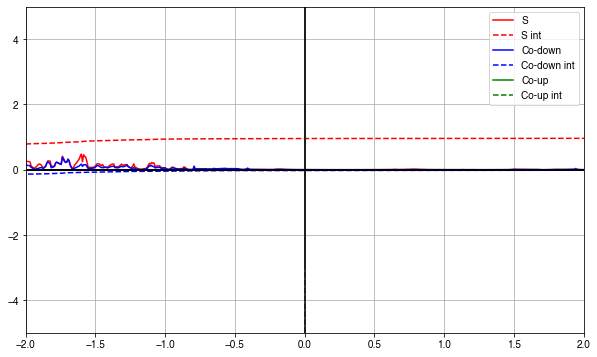

In [19]:
# spin-polarized (dos is halved) and 2 Ta per f.u., 2 f.u. per u.c. 
line_idx = 1
fig = pyplot.figure(figsize=(10,6))

iters = [(0, 'S', False, 'red'), (1, 'Co-down', True, 'blue'), (2, 'Co-up', False, 'green'), (3, 'Total', False, 'grey')]

print('### U = 0 ###')
for line_idx, label, down, color in iters[:-1]:
    integrate(axes[0], line_idx, 1, 2, label=label, down=down, color=color)

pyplot.ylim(-5,5)
pyplot.xlim(-2,2)
pyplot.axvline(x=0, color='k')
pyplot.show()